In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
from pylab import cm
import torch
import torch.nn as nn
torch.manual_seed(2)
from torch.nn import functional as F
import sys
from google.colab import drive

from torch.distributions import Normal
from typing import List
from tqdm import tqdm
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

drive.mount('/content/drive')
sys.path.append('drive/MyDrive/ATML_HT22')
from models import *
import seaborn as sns
sns.set()
%load_ext autoreload
%autoreload 2

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
DRIVE_ROOT='/content/drive/MyDrive'
# example loading a model for continued training
def load_model(model, name):
  path = f"{DRIVE_ROOT}/saved_models/{name}" 
  checkpoint = torch.load(path, map_location=DEVICE)
  

  model.load_state_dict(checkpoint['model'])
  # optimizer.load_state_dict(checkpoint('optimizer'))
  
  model.eval()

  return model

In [3]:
from utils import load_model


from train import test
from eval import estimate_marginal_likelihood
from train import train_and_test
from eval import BinaryMNIST

%load_ext autoreload
%autoreload 2




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:

model, optimizer, steps, train_losses, settings = load_model("k0_bMNIST", DEVICE) # just to get the settings
batch_size, optim_lr, rms_prop_momentum, num_training_steps,\
  imp_samples, D, encoder_hidden_dims, decoder_hidden_dims, latent_size,\
  maxout_window_size, non_linearity, optim_type, flow_type, num_flow_blocks, binary = settings

train_loader, test_loader = BinaryMNIST(batch_size)

In [5]:
N=200
Planar_nnl=[]

In [6]:

for k, name  in enumerate(['k0_bMNIST', 'k10_bMNIST_v2','k20_bMNIST_v2','k40_bMNIST_v2',]):
  # if k<3: continue

  model, optimizer, steps, train_losses, settings = load_model(name, DEVICE)
  


  marg_log_lik = estimate_marginal_likelihood(N, test_loader, binary, model, DEVICE)
  Planar_nnl.append( marg_log_lik)
  print(f"Marginal log likelihood: {marg_log_lik:.2f} for {name}")

  model, optimizer, train_losses=None, None, None
  torch.cuda.empty_cache()

  

Marginal log likelihood: 92.39 for k0_bMNIST
Marginal log likelihood: 89.95 for k10_bMNIST_v2
Marginal log likelihood: 89.32 for k20_bMNIST_v2
Marginal log likelihood: 88.92 for k40_bMNIST_v2


In [7]:
Planar_nnl.append(88.74) # calculated with the CPU since k80 likelihood calculation wasn't fitting in the GPU memory 

In [8]:
Sylv_nnl = []

In [9]:
for k, name  in enumerate(['k2_bMNIST_TriangularSylvester','k8_bMNIST_TriangularSylvester','k16_bMNIST_TriangularSylvester','k40_bMNIST_TriangularSylvester',]):
  model, optimizer, steps, train_losses, settings = load_model(name, DEVICE)
  
  marg_log_lik = estimate_marginal_likelihood(N, test_loader, binary, model, DEVICE)
  Sylv_nnl.append(marg_log_lik)
  print(f"Marginal log likelihood: {marg_log_lik:.2f} for {name}")

  model, optimizer, train_losses=None, None, None
  torch.cuda.empty_cache()

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:493: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Marginal log likelihood: 88.85 for k2_bMNIST_TriangularSylvester
Marginal log likelihood: 88.30 for k8_bMNIST_TriangularSylvester
Marginal log likelihood: 88.17 for k16_bMNIST_TriangularSylvester
Marginal log likelihood: 88.04 for k40_bMNIST_TriangularSylvester


In [10]:
def annealed_ELBO(x, recon, log_p_zo, log_p_zk, log_det_sum, binary=True, beta_t=1.):

    if binary:
        CE = F.binary_cross_entropy(recon, x, reduction='sum')


    KL = torch.sum(log_p_zo, -1) - torch.sum(log_p_zk, -1)

    F_bt = CE+KL
                                             
    # happens if k=0
    if type(log_det_sum) != float:
       F_bt -= torch.sum(log_det_sum.view(-1))
    return KL, F_bt


def test(model, testing_loader, binary, device, print_progress=True, N=1):

    model.eval()
    total_loss = 0.
    totoal_KL = 0.0
    for _ in range(N):
      with torch.no_grad():
          for i, (x, _) in enumerate(testing_loader):
              x = x.flatten(1).to(device)
              recon, logp_zo, logp_zk, log_det_sum = model(x)
              KL, loss = annealed_ELBO(x, recon, logp_zo, logp_zk, log_det_sum, binary )
              total_loss += loss.detach().item()
              totoal_KL +=KL.detach().item()

    total_loss /= len(testing_loader.dataset)*N
    totoal_KL /= len(testing_loader.dataset)*N



    return total_loss, totoal_KL


   

In [11]:
Planar_KL = []
Planar_loss = []
for k, name  in enumerate(['k0_bMNIST', 'k10_bMNIST_v2','k20_bMNIST_v2','k40_bMNIST_v2', 'k80_bMNIST_v2']): 
  model, optimizer, steps, train_losses, settings = load_model(name, DEVICE)

  train_loader, test_loader = BinaryMNIST(batch_size)

  F_bt, KL=test(model, test_loader, True, DEVICE, N=N)
  Planar_KL.append(KL)
  Planar_loss.append(F_bt)

  
  print(f"model name ={name}==> Fft= {F_bt:.2f}, KL ={KL:.2f}")

  model, optimizer, train_losses=None, None, None
  torch.cuda.empty_cache()


model name =k0_bMNIST==> Fft= 96.99, KL =29.18
model name =k10_bMNIST_v2==> Fft= 93.97, KL =28.07
model name =k20_bMNIST_v2==> Fft= 93.02, KL =27.86
model name =k40_bMNIST_v2==> Fft= 92.47, KL =26.68
model name =k80_bMNIST_v2==> Fft= 92.21, KL =24.21


In [12]:
Sylv_KL = []
Sylv_loss = []
for k, name  in enumerate(['k2_bMNIST_TriangularSylvester','k8_bMNIST_TriangularSylvester','k16_bMNIST_TriangularSylvester','k40_bMNIST_TriangularSylvester',]):


  model, optimizer, steps, train_losses, settings = load_model(name, DEVICE)

  F_bt, KL=test(model, test_loader, True, DEVICE,  N=N)
  Sylv_KL.append(KL)
  Sylv_loss.append(F_bt)
  print(f"model name ={name}==> Fft= {F_bt:.2f}, KL ={KL:.2f}")


  model, optimizer, train_losses=None, None, None
  torch.cuda.empty_cache()

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:493: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


model name =k2_bMNIST_TriangularSylvester==> Fft= 92.32, KL =36.36
model name =k8_bMNIST_TriangularSylvester==> Fft= 91.43, KL =30.58
model name =k16_bMNIST_TriangularSylvester==> Fft= 91.21, KL =24.56
model name =k40_bMNIST_TriangularSylvester==> Fft= 91.20, KL =18.55


In [13]:
planar_x = np.array([0, 10, 20, 40, 80])
sylv_x= np.array([2, 8, 16, 40])
yerr = np.ones(len(sylv_x))*0.1
yerr2 = np.ones(len(planar_x))*0.1

In [14]:
def plot_performance(ax, x, y, err, label, y_axis_label):
  ax.errorbar(x,np.array(y),yerr=err, label=f"{label}", elinewidth=4)
  ax.legend()
  ax.set_xlabel("Flow Length")
  ax.set_ylabel(f"{y_axis_label}")


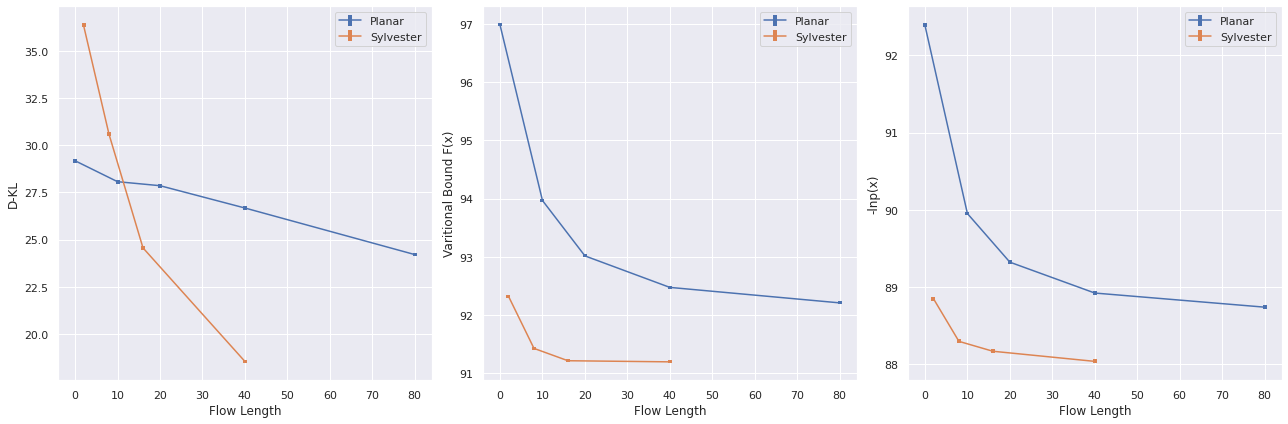

In [15]:
fig, axes =plt.subplots(1, 3, figsize=(18,6))

i =0

plot_performance(axes[i], planar_x, Planar_KL, yerr2, "Planar", "D-KL")
plot_performance(axes[i], sylv_x, Sylv_KL, yerr, "Sylvester", "D-KL")

yerr /=4
yerr2 /=4
i+=1

plot_performance(axes[i], planar_x, Planar_loss, yerr2, "Planar", "Varitional Bound F(x)")
plot_performance(axes[i], sylv_x, Sylv_loss, yerr, "Sylvester", "Varitional Bound F(x)")

i+=1
plot_performance(axes[i], planar_x, Planar_nnl, yerr2, "Planar", "-lnp(x)")
plot_performance(axes[i], sylv_x, Sylv_nnl, yerr, "Sylvester", "-lnp(x)")




fig.tight_layout()

# plt.show()
fig.savefig('comparison_figure.pdf') 